# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [154]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [155]:
CANCER_DATA_PATH = '/Users/olga/Downloads/BI_ML21_HW-main-2/hw2_data/cancer.csv'
SPAM_DATA_PATH = '/Users/olga/Downloads/BI_ML21_HW-main-2/hw2_data/spam.csv'

In [156]:
cancer_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-2/hw2_data/cancer.csv')
print(cancer_data.head(5))

  label      1      2       3       4        5        6       7        8  \
0     M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001  0.14710   
1     M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869  0.07017   
2     M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974  0.12790   
3     M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414  0.10520   
4     M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980  0.10430   

        9  ...     21     22      23      24      25      26      27      28  \
0  0.2419  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.1812  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.2069  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.2597  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.1809  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       29       30  
0  0.4601  0.11890  
1  0.2750  0.08902  

In [157]:
spam_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-2/hw2_data/spam.csv')
print(spam_data.head(5))

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_:  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

In [158]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    cancer_data = pd.read_csv(path_to_csv)
    X = cancer_data.drop('label', axis=1).values 
    y = cancer_data['label'].values 
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    spam_data = pd.read_csv(path_to_csv)
    X = spam_data.drop('label', axis=1).values 
    y = spam_data['label'].values 
    return X, y

In [159]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [160]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    if ratio > 1 or ratio < 0:
        print('Ratio must be between 0 and 1')
        return None
    train_indices = np.random.choice(range(X.shape[0]), int(ratio * X.shape[0]))
    X_train = X[train_indices]
    X_test = X[~train_indices]
    y_train = y[train_indices]
    y_test = y[~train_indices]
    return X_train, y_train, X_test, y_test

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [161]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    classes = np.unique(y_true)
    precision = []
    recall = []
    accuracy = 0
    for c in classes:
        TP = len([i for i in range(len(y_pred)) if (y_pred[i] == c and y_true[i] == c)])
        FP = len([i for i in range(len(y_pred)) if (y_pred[i] == c and y_true[i] != c)])
        FN = len([i for i in range(len(y_pred)) if (y_pred[i] != c and y_true[i] == c)])
        precision.append(TP / (TP + FP))
        recall.append(TP / (TP + FN))
    accuracy = len([i for i in range(len(y_pred)) if (y_pred[i] == y_true[i])]) / len(y_pred)
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [162]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(X_train, y_train, k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [163]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(X_train, y_train, k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [164]:
class Node:
    def __init__(self, sample=None, label=None, split_feature=None, parent=None, left=None, right=None):
        self.sample = sample
        self.label = label
        self.split_feature = split_feature
        self.parent = parent
        self.left = left
        self.right = right

In [165]:
class KNearest:
    def __init__(self, X, y, n_neighbours=5):
        self.n_neighbours = n_neighbours
        self.depth = 0
        self.root = self.fit(X, y) # строим дерево
        self.classes = np.unique(y)
    
    def fit(self, X, y, parent = None):
        num_samples, num_features = X.shape
        y = y.reshape(num_samples, 1)
        if num_samples == 0:
            return None # пустое дерево, не из чего строить
        variations = [np.var(X[:, i]) for i in range(num_features)] # считаем дисперсию вдоль всех колонок
        split_feat = variations.index(max(variations)) # разбиваем по признаку с наибольшей дисперсией
        split_indices = X[:, split_feat].argsort()
        median_ix = split_indices[num_samples // 2]
        if num_samples == 1:
            self.depth += 1
            return Node(sample=X[median_ix], label=y[median_ix], split_feature=split_feat, parent=parent, left=None, right=None)
        node = Node(sample=X[median_ix], label=y[median_ix], split_feature=split_feat, parent=parent, left=None, right=None)
        left_child = self.fit(X[split_indices[:num_samples // 2]], y[split_indices[:num_samples // 2]], node)
        if num_samples == 2:
            right_child = None
        else:
            right_child = self.fit(X[split_indices[num_samples // 2 + 1:]], y[split_indices[num_samples // 2 + 1:]], node)
        node.left = left_child
        node.right = right_child
        self.depth += 1
        return node
    
    def find_nearest_neighbour(self, sample):
        if self.depth == 0:
            return None
        node = self.root
        if self.depth == 1:
            return node
        while True:
            if sample[node.split_feature] == node.sample[node.split_feature]:
                return node
            elif sample[node.split_feature] < node.sample[node.split_feature]:
                if node.left == None:
                    return node
                node = node.left
            else:
                if node.right == None:
                    return node
                node = node.right
                
    def info_list(self, node, info=[]):
        if node is None:
            return None
        sample_dict = {'sample':tuple(node.sample), 'label':node.label[0],
                      'split_feature':node.split_feature,
                       'parent':tuple(node.parent.sample) if node.parent else None,
                      'left':tuple(node.left.sample) if node.left else None,
                      'right':tuple(node.right.sample) if node.right else None}
        info.append(sample_dict)
        self.info_list(node.left, info)
        self.info_list(node.right, info)
        return info
                
    def knn(self, sample):
        if self.depth <= self.n_neighbours:
            labels_dict = {}
            for tree_sample in self.info_list(self.root):
                if tree_sample['label'] in labels_dict:
                    labels_dict[tree_sample['label']] += 1
                else:
                    labels_dict[tree_sample['label']] = 1
            sorted_labels = sorted(labels_dict.items(), key=lambda item: item[1], reverse=True)
            return sorted_labels
        node = self.find_nearest_neighbour(sample)
        if node == None:
            return None
        nearest_nodes = []
        distance = np.linalg.norm(sample - node.sample)
        farthest = distance
        nearest_nodes.append([distance, tuple(node.sample), node.label[0]])
        if node.left != None:
            left = node.left
            left_distance = np.linalg.norm(sample - left.sample)
            if self.n_neighbours > len(nearest_nodes) or left_distance < farthest:
                nearest_nodes.append([left_distance, tuple(left.sample), left.label[0]])
                nearest_nodes.sort()
                farthest = nearest_nodes[-1][0] if self.n_neighbours >= len(nearest_nodes) else nearest_nodes[self.n_neighbours - 1][0]
        while True:
            if node == self.root:
                break
            parent = node.parent
            parent_distance = np.linalg.norm(sample - parent.sample)
            if self.n_neighbours > len(nearest_nodes) or parent_distance < farthest:
                nearest_nodes.append([parent_distance, tuple(parent.sample), parent.label[0]])
                nearest_nodes.sort()
                farthest = nearest_nodes[-1][0] if self.n_neighbours >= len(nearest_nodes) else nearest_nodes[self.n_neighbours - 1][0]
            if self.n_neighbours > len(nearest_nodes) or abs(sample[parent.split_feature] - parent.sample[parent.split_feature]) < farthest:
                other = parent.left if parent.left != node else parent.right
                if other != None:
                    if sample[parent.split_feature] <= parent.sample[parent.split_feature]:
                        self.search_to_the_left(sample, other, nearest_nodes)
                    else:
                        self.search_to_the_right(sample, other, nearest_nodes)
            node = parent
        labels_dict = {}
        nearest_nodes = nearest_nodes[:self.n_neighbours]
        for tree_sample in nearest_nodes:
            if tree_sample[2] in labels_dict:
                labels_dict[tree_sample[2]] += 1
            else:
                labels_dict[tree_sample[2]] = 1
        sorted_labels = sorted(labels_dict.items(), key=lambda item: item[1], reverse=True)
        return sorted_labels, nearest_nodes
    
    def search_to_the_left(self, sample, node, node_list):
        node_list.sort()
        farthest = node_list[-1][0] if self.n_neighbours >= len(node_list) else node_list[self.n_neighbours - 1][0]
        if node.left == None and node.right == None:
            distance = np.linalg.norm(sample - node.sample)
            if self.n_neighbours > len(node_list) or distance < farthest:
                node_list.append([distance, tuple(node.sample), node.label[0]])
            return 
        self.search_to_the_left(sample, node.left, node_list)
        node_list.sort()
        farthest = node_list[-1][0] if self.n_neighbours >= len(node_list) else node_list[self.n_neighbours - 1][0]
        distance = np.linalg.norm(sample - node.sample)
        if self.n_neighbours > len(node_list) or distance < farthest:
            node_list.append([distance, tuple(node.sample), node.label[0]])
        if self.n_neighbours > len(node_list) or abs(sample[node.split_feature] - node.sample[node.split_feature]) < farthest:
            if node.right != None:
                self.search_to_the_left(sample, node.right, node_list)
        return node_list
    
    def search_to_the_right(self, sample, node, node_list):
        node_list.sort()
        farthest = node_list[-1][0] if self.n_neighbours >= len(node_list) else node_list[self.n_neighbours - 1][0]
        if node.left == None and node.right == None:
            distance = np.linalg.norm(sample - node.sample)
            if self.n_neighbours > len(node_list) or distance < farthest:
                node_list.append([distance, tuple(node.sample), node.label[0]])
            return 
        if node.right != None:
            self.search_to_the_right(sample, node.right, node_list)
        node_list.sort()
        farthest = node_list[-1][0] if self.n_neighbours >= len(node_list) else node_list[self.n_neighbours - 1][0]
        distance = np.linalg.norm(sample - node.sample)
        if self.n_neighbours > len(node_list) or distance < farthest:
            node_list.append([distance, tuple(node.sample), node.label[0]])
        if self.n_neighbours > len(node_list) or abs(sample[node.split_feature] - node.sample[node.split_feature]) < farthest:
            self.search_to_the_right(sample, node.left, node_list)
        return node_list
    
    def predict_sample_proba(self, neighbours):
        neighbour_labels = {}
        for i in range(len(neighbours)):
            l = neighbours[i][-1]
            if l in neighbour_labels:
                neighbour_labels[l] += 1
            else:
                neighbour_labels[l] = 1
        sorted_labels = sorted(neighbour_labels.items(), key=lambda item: item[1], reverse=True)
        sample_proba = [0] * len(self.classes)
        for l in list(neighbour_labels.keys()):
            sample_proba[l] = neighbour_labels[l] / len(neighbours)
        return sample_proba
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        proba_matrix = []
        for x in X:
            label_dict, neighbours = self.knn(x)
            proba_matrix.append(self.predict_sample_proba(neighbours))
        proba_matrix = np.array(proba_matrix)
        return proba_matrix
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных

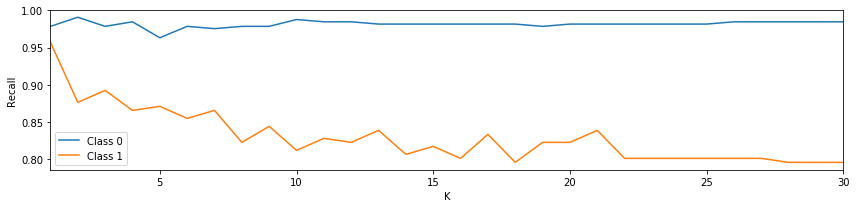

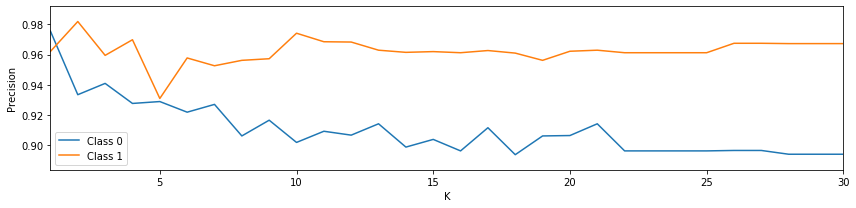

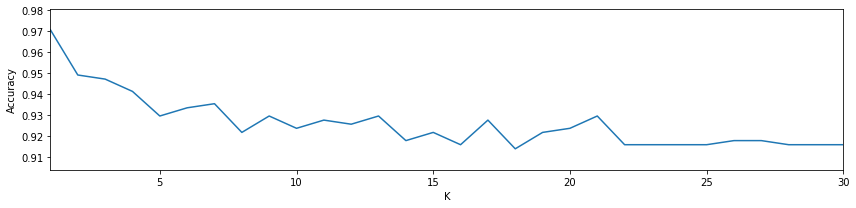

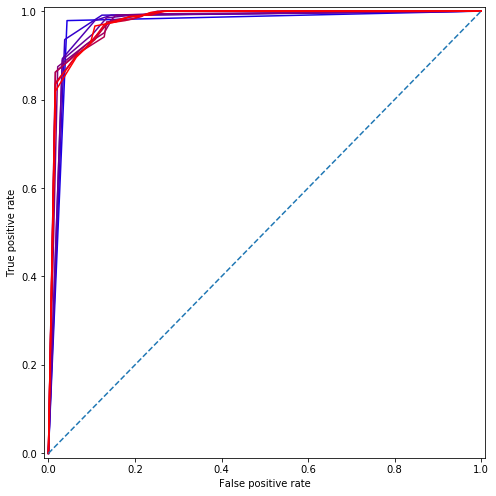

In [166]:
le = LabelEncoder()
y_cancer = le.fit_transform(y_cancer) # 1 - злокачественная, 0 - доброкачественная
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

В этой задаче, наверное, лучшее значение k - это 1, поскольку в этом случае у нас наблюдается лучшее значение recall для класса 1 (злокачественная опухоль), его угадывание очень важно; остальные параметры также в этом случае являются лучшими.

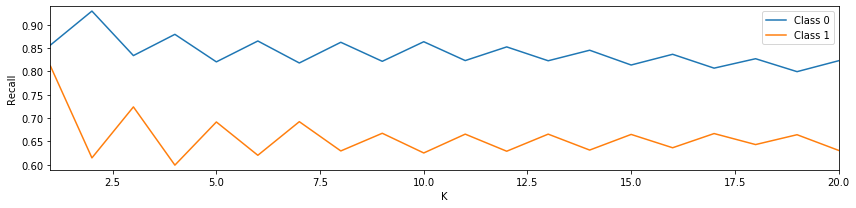

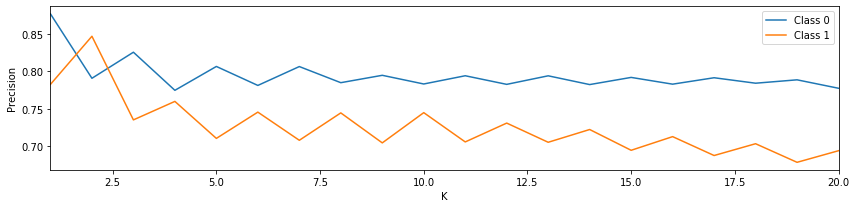

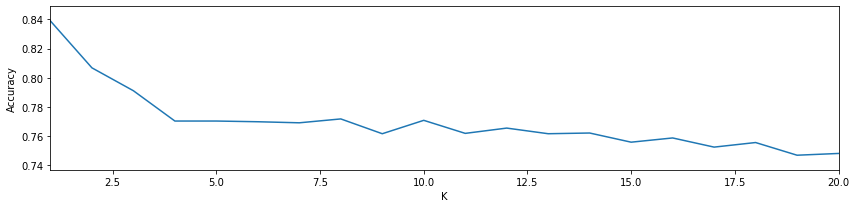

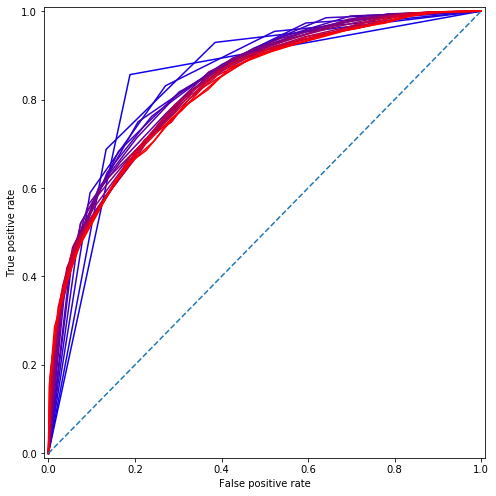

In [167]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

Здесь тоже лучшим является k = 1 по тем же самым причинам.

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

Про параметр k - см. выше. Лучшей из представленных метрик является ROC-кривая, поскольку она визуализирует соотношение между precision и recall и позволяет найти баланс между ними. В этом же смысле хорошей метрикой является f1-score. Accuracy зачастую не отражает качество модели, поскольку классы могут быть несбалансированными по количеству и важности.

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [168]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
#import cv2
from collections import deque
from scipy.spatial import distance
from collections import Counter

In [169]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    #colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

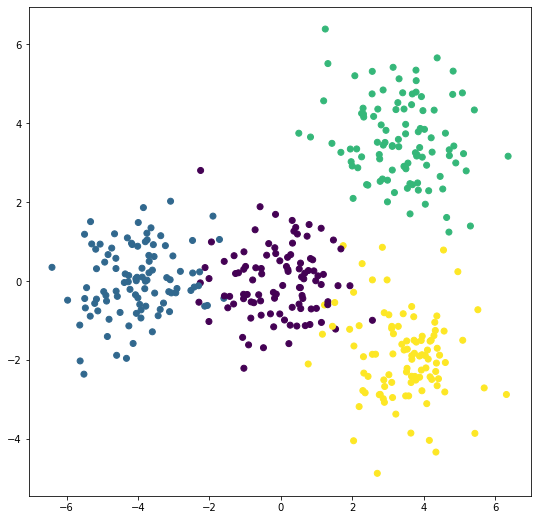

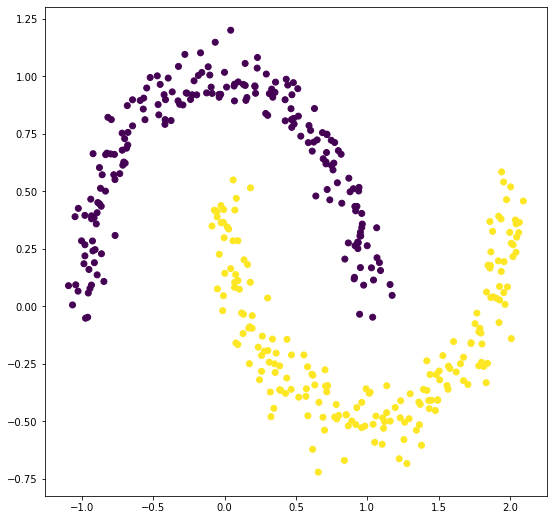

In [170]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [171]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, tol=0.001):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        
    def initialize(self, X):
        np.random.seed(0)
        np.set_printoptions(suppress=True)
        rng = np.random.default_rng()
        if self.init == 'random':
            C_x = np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), size=self.n_clusters)
            C_y = np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), size=self.n_clusters)
            self.centroids = np.array(list(zip(C_x, C_y)))
        elif self.init == 'sample':
            indices = rng.choice(np.arange(len(X)), self.n_clusters, replace = True)
            self.centroids = X[indices]
        elif self.init == 'k-means++':
            indices_chosen = []
            self.centroids = []
            first_centroid_ix = np.random.randint(0, len(X) - 1)
            indices_chosen.append(first_centroid_ix)
            self.centroids.append(X[first_centroid_ix])
            for i in range(self.n_clusters - 1):
                indices_chosen = np.array(indices_chosen)
                distances = np.array([np.min(np.linalg.norm(X[i] - self.centroids, axis=1)) for i in range(len(X)) if i not in indices_chosen])
                distr = distances**2 / np.sum(distances**2)
                a = np.arange(len(X))
                mask = np.array([i for i in range(len(X)) if i not in indices_chosen])
                next_centroid_ix = rng.choice(a[mask], 1, replace = True, p = distr)[0]
                indices_chosen = list(indices_chosen)
                indices_chosen.append(next_centroid_ix)
                self.centroids.append(X[next_centroid_ix])
                
    def fit_predict(self, X, y=None):
        self.initialize(X)
        self.centroids = np.array(self.centroids)
        iteration = 0
        old_centres = np.empty(self.centroids.shape)
        labels = [0] * len(X)
        centre_change = None
        iteration += 1
        for i in range(len(X)):
            dist_to_centres = np.linalg.norm(self.centroids - X[i], axis=1)
            labels[i] = np.argmin(dist_to_centres)
        old_centres[:] = self.centroids
        for j in range(self.n_clusters):
            one_cluster_points = np.array([X[i] for i in range(len(X)) if labels[i] == j])
            if len(one_cluster_points) != 0:
                self.centroids[j] = np.mean(one_cluster_points, axis=0)
        centre_change = np.allclose(old_centres, self.centroids, atol=self.tol)
        while (centre_change == False) and (iteration < self.max_iter):
            iteration += 1
            for i in range(len(X)):
                dist_to_centres = np.linalg.norm(self.centroids - X[i], axis=1)
                labels[i] = np.argmin(dist_to_centres)
            old_centres[:] = self.centroids
            for j in range(self.n_clusters):
                one_cluster_points = np.array([X[i] for i in range(len(X)) if labels[i] == j])
                if len(one_cluster_points) != 0:
                    self.centroids[j] = np.mean(one_cluster_points, axis=0)
            centre_change = np.allclose(old_centres, self.centroids, atol=self.tol)
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

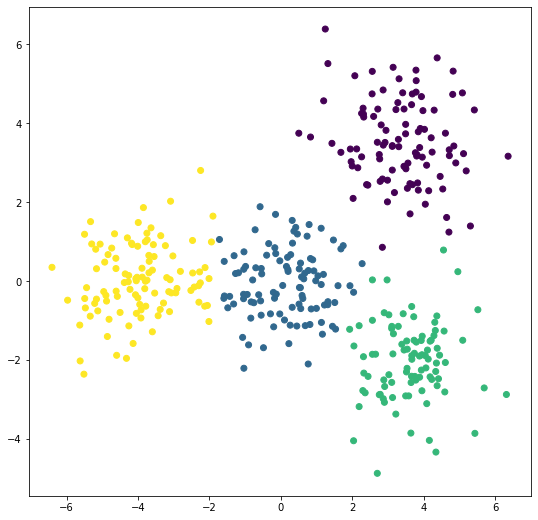

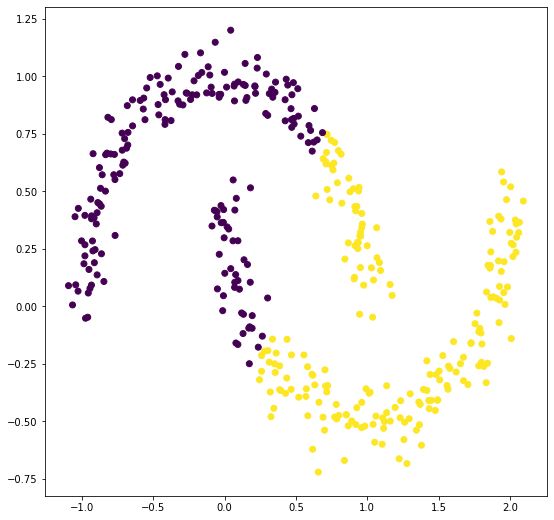

In [172]:
kmeans = KMeans(n_clusters=4, init='sample')
kmeans_labels_1 = kmeans.fit_predict(X_1)
#labels = kmeans.predict(X_1)
visualize_clasters(X_1, kmeans_labels_1)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans_labels_2 = kmeans.fit_predict(X_2)
#labels = kmeans.predict(X_2)
visualize_clasters(X_2, kmeans_labels_2)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [173]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        eps = self.eps
        m = self.min_samples
        
        def dbscan_get_neighbours(point_id, distances, eps):
            return np.where((distances[point_id][:] > 0) & (distances[point_id][:] < eps))[0]

        def dbscan_get_recursive_neighbours(points, distances, checked_points, m, eps):
            new_checked_points = set(checked_points)
            for point in points:
                if point not in new_checked_points:
                    new_checked_points.add(point)
                    point_neighbours = dbscan_get_neighbours(point, distances, eps)
                    if point_neighbours.shape[0] >= m:
                        new_checked_points = new_checked_points.union(
                            dbscan_get_recursive_neighbours(point_neighbours, distances,
                                                            new_checked_points, m, eps))
            return new_checked_points

        import random
        distances = distance.cdist(X, X, metric=self.metric)
        n = X.shape[0]
        noise_points = set([])
        unknown_points = set([])
        unchecked_points = set(np.arange(n))
        point2class = np.zeros(n)
        cur_class = 1
        while len(unchecked_points) > 0:
            start_point = list(unchecked_points)[0]
            unchecked_points.remove(start_point)
            point_neighbours = dbscan_get_neighbours(start_point, distances, eps)
            if point_neighbours.shape[0] == 0:
                noise_points.add(start_point)
            elif point_neighbours.shape[0] < m:
                unknown_points.add(start_point)
            else:
                point2class[start_point] = cur_class

                checked_points = set(np.arange(n)) - unchecked_points
                new_checked_points = dbscan_get_recursive_neighbours(point_neighbours, distances,
                                                                     checked_points, m, eps)
                for point in new_checked_points:
                    if point not in checked_points:
                        unchecked_points.remove(point)
                        point2class[point] = cur_class
                checked_points = new_checked_points
                cur_class += 1
        for point in unknown_points:
            point_neighbours = dbscan_get_neighbours(point, distances, eps)
            classes = point2class[point_neighbours]
            classes = classes[classes > 0]
            if classes.shape[0] > 0:
                point2class[point] = int(Counter(classes).most_common()[0][0])
        return np.array(point2class, dtype='int')

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

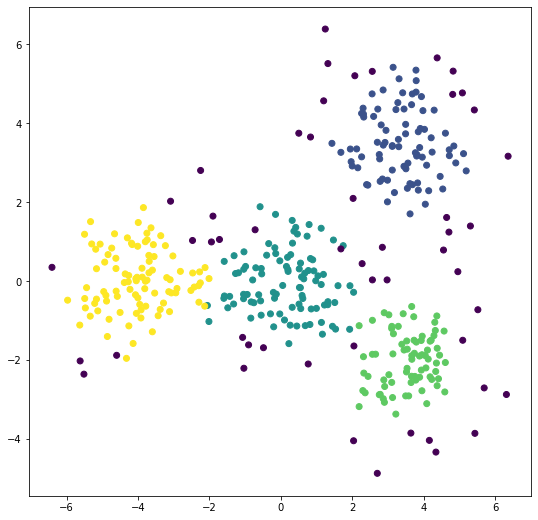

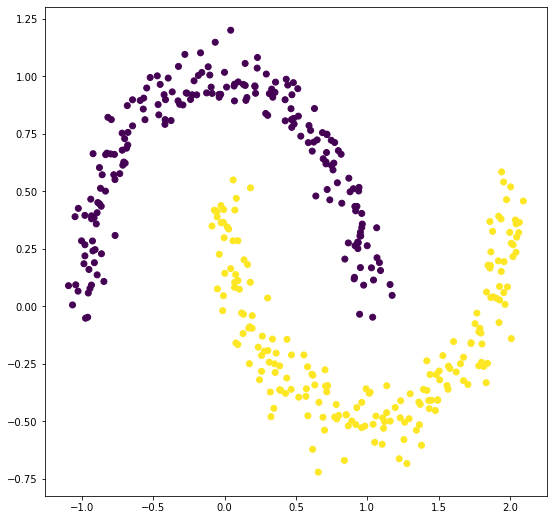

In [174]:
dbscan = DBScan()
dbscan_labels_1 = dbscan.fit_predict(X_1)
visualize_clasters(X_1, dbscan_labels_1)


dbscan = DBScan(eps=0.2)
dbscan_labels_2 = dbscan.fit_predict(X_2)
visualize_clasters(X_2, dbscan_labels_2)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

С кластеризацией "капелек" лучше справился kmeans, поскольку плотность и размер кластеров были примерно одинаковыми; с кластеризацией "лун" лучше справился dbscan, поскольку, во-первых, сыграло роль геометрическое расположение точек (более сложное), во-вторых, основная проблема kmeans здесь - начальный выбор центров кластеров даже в случае k-means++ (если мы выбираем начальные центры кластеров в одной "луне", то далее классификация правильной не будет).

In [87]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [92]:
print(f'Davies-Bouldin index for blobs (kmeans): {davies_bouldin_score(X_1, kmeans_labels_1)}')
print(f'Davies-Bouldin index for blobs (dbscan): {davies_bouldin_score(X_1, dbscan_labels_1)}')
print('-------------------------------------------------------')
print(f'Silhouette score for blobs (kmeans): {silhouette_score(X_1, kmeans_labels_1)}')
print(f'Silhouette score for blobs (dbscan): {silhouette_score(X_1, dbscan_labels_1)}')
print('-------------------------------------------------------')
print(f'Davies-Bouldin index for moons (kmeans): {davies_bouldin_score(X_2, kmeans_labels_2)}')
print(f'Davies-Bouldin index for moons (dbscan): {davies_bouldin_score(X_2, dbscan_labels_2)}')
print('-------------------------------------------------------')
print(f'Silhouette score for moons (kmeans): {silhouette_score(X_2, kmeans_labels_2)}')
print(f'Silhouette score for moons (dbscan): {silhouette_score(X_2, dbscan_labels_2)}')

Davies-Bouldin index for blobs (kmeans): 0.5633136949339121
Davies-Bouldin index for blobs (dbscan): 2.0189712094292704
-------------------------------------------------------
Silhouette score for blobs (kmeans): 0.5749526970475735
Silhouette score for blobs (dbscan): 0.28146957142381424
-------------------------------------------------------
Davies-Bouldin index for moons (kmeans): 0.7730846959731271
Davies-Bouldin index for moons (dbscan): 1.1783149076394412
-------------------------------------------------------
Silhouette score for moons (kmeans): 0.4919999566416307
Silhouette score for moons (dbscan): 0.3213106426631888


Davies-Bouldin score: чем меньше, тем лучше. <br>
Silhouette score: лучшее значение - 1, худшее - -1 (чем больше, тем лучше).

### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [175]:
class AgglomertiveClustering:
    def __init__(self, linkage="average"):
        self.linkage = linkage
    
    def fit_predict(self, X, y=None):
        def get_agglomerates(distances, clusters):
            if self.linkage == 'complete':
                clusters_distances = []
                for i, points_i in clusters.items():
                    for j, points_j in clusters.items():
                        if i == j:
                            continue
                        max_distance = 0
                        for point_i in points_i:
                            for point_j in points_j:
                                if distances[point_i][point_j] > max_distance:
                                    max_distance = distances[point_i][point_j]
                        clusters_distances.append((max_distance, i, j))
                _, cluster1, cluster2 = sorted(clusters_distances)[0]
                return cluster1, cluster2
            elif self.linkage == 'single':
                clusters_distances = []
                for i, points_i in clusters.items():
                    for j, points_j in clusters.items():
                        if i == j:
                            continue
                        min_distance = np.inf
                        for point_i in points_i:
                            for point_j in points_j:
                                if distances[point_i][point_j] < min_distance:
                                    min_distance = distances[point_i][point_j]
                        clusters_distances.append((min_distance, i, j))
                _, cluster1, cluster2 = sorted(clusters_distances)[0]
                return cluster1, cluster2
            elif self.linkage == 'average':
                clusters_distances = []
                for i, points_i in clusters.items():
                    for j, points_j in clusters.items():
                        if i == j:
                            continue
                        ave_distance = []
                        for point_i in points_i:
                            for point_j in points_j:
                                ave_distance.append(distances[point_i][point_j])
                        clusters_distances.append((np.mean(ave_distance), i, j))
                _, cluster1, cluster2 = sorted(clusters_distances)[0]
                return cluster1, cluster2

        from collections import defaultdict
        n = X.shape[0]
        clusters = defaultdict(list)
        for point_id in range(X.shape[0]):
            clusters[point_id].append(point_id)
        distances = distance.cdist(X, X, metric='euclidean')
        clusters_history = []
        clusters_cnt = len(clusters.keys())
        while(clusters_cnt > 1):
            clusters_history.append(dict(clusters))
            cluster1, cluster2 = get_agglomerates(distances, clusters)
            for point_id in clusters[cluster2]:
                clusters[cluster1].append(point_id)
            del clusters[cluster2]
            clusters_cnt = len(clusters.keys())
        return clusters_history

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [180]:
agg_clustering = AgglomertiveClustering()
clusters_history = agg_clustering.fit_predict(X_1)

Number of clusters: 4


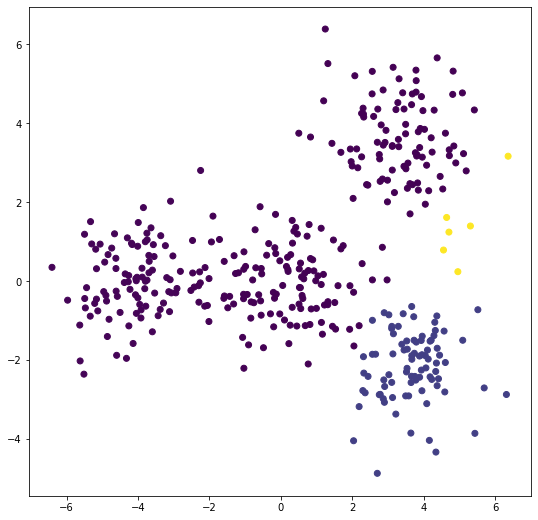

In [181]:
epoch = 395
ac_classes_1 = np.zeros(X_1.shape[0])
for cluster, points in clusters_history[epoch].items():
    for point in points:
        ac_classes_1[point] = cluster
print(f'Number of clusters: {len(Counter(ac_classes_1))}')
visualize_clasters(X_1, ac_classes_1)

In [182]:
agg_clustering = AgglomertiveClustering(linkage='single')
clusters_history = agg_clustering.fit_predict(X_2)

Number of clusters: 2


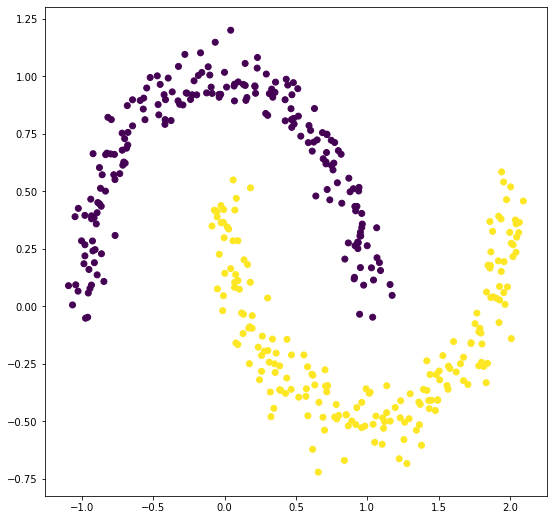

In [183]:
epoch = 398
ac_classes_2 = np.zeros(X_2.shape[0])
for cluster, points in clusters_history[epoch].items():
    for point in points:
        ac_classes_2[point] = cluster
print(f'Number of clusters: {len(Counter(ac_classes_2))}')
visualize_clasters(X_2, ac_classes_2)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [184]:
print(f'Davies-Bouldin index for blobs (kmeans): {davies_bouldin_score(X_1, kmeans_labels_1)}')
print(f'Davies-Bouldin index for blobs (dbscan): {davies_bouldin_score(X_1, dbscan_labels_1)}')
print(f'Davies-Bouldin index for blobs (agglomerative clustering): {davies_bouldin_score(X_1, ac_classes_1)}')
print('-------------------------------------------------------')
print(f'Silhouette score for blobs (kmeans): {silhouette_score(X_1, kmeans_labels_1)}')
print(f'Silhouette score for blobs (dbscan): {silhouette_score(X_1, dbscan_labels_1)}')
print(f'Silhouette score for blobs (agglomerative clustering): {silhouette_score(X_1, ac_classes_1)}')
print('-------------------------------------------------------')
print(f'Davies-Bouldin index for moons (kmeans): {davies_bouldin_score(X_2, kmeans_labels_2)}')
print(f'Davies-Bouldin index for moons (dbscan): {davies_bouldin_score(X_2, dbscan_labels_2)}')
print(f'Davies-Bouldin index for moons (agglomerative clustering): {davies_bouldin_score(X_2, ac_classes_2)}')
print('-------------------------------------------------------')
print(f'Silhouette score for moons (kmeans): {silhouette_score(X_2, kmeans_labels_2)}')
print(f'Silhouette score for moons (dbscan): {silhouette_score(X_2, dbscan_labels_2)}')
print(f'Silhouette score for moons (agglomerative clustering): {silhouette_score(X_2, ac_classes_2)}')

Davies-Bouldin index for blobs (kmeans): 0.5641730848930147
Davies-Bouldin index for blobs (dbscan): 2.0453508574758996
Davies-Bouldin index for blobs (agglomerative clustering): 0.8636437925833047
-------------------------------------------------------
Silhouette score for blobs (kmeans): 0.568446929410913
Silhouette score for blobs (dbscan): 0.4690735279015248
Silhouette score for blobs (agglomerative clustering): 0.26938782712661125
-------------------------------------------------------
Davies-Bouldin index for moons (kmeans): 0.7783903105783762
Davies-Bouldin index for moons (dbscan): 1.1568430025434044
Davies-Bouldin index for moons (agglomerative clustering): 1.1568430025434044
-------------------------------------------------------
Silhouette score for moons (kmeans): 0.4871183674951641
Silhouette score for moons (dbscan): 0.3286815406775122
Silhouette score for moons (agglomerative clustering): 0.3286815406775122


По метрикам для обоих датасетов лучшей кластеризацией является kmeans, хотя на самом деле для датасета moons лучшими кластеризациями являются dbscan и agglomerative clustering.